In [263]:
import pandas as pd
import numpy as np

df = pd.read_csv("amz_uk_price_prediction_dataset.csv")


In [264]:
# Check basic info
print(df.info())

# Check missing values
print(df.isnull().sum())

# Quick look at first rows
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB
None
uid                  0
asin                 0
title                0
stars                0
reviews              0
price                0
isBestSeller         0
boughtInLastMonth    0
category             0
dtype: int64
   uid        asin                                              title  stars  \
0    1  B09B96TG33  Echo Dot (5th generation, 2022 release) | Big ...    4.7   
1    2  B01HTH3C8S  Anker Soundcore mini, Super-Portable Bluetooth...    4.7  

In [265]:
df = df.dropna(subset=['price', 'stars', 'category', 'isBestSeller'])


In [266]:
df = df.drop_duplicates(subset=['asin','title','category'])  # unique products


In [267]:
df['category'] = df['category'].astype('category')
df['isBestSeller'] = df['isBestSeller'].astype('bool')


In [268]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['stars'] = pd.to_numeric(df['stars'], errors='coerce')



In [269]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

df_clean = df[(df['price'] >= (Q1 - 1.5*IQR)) & (df['price'] <= (Q3 + 1.5*IQR))]


In [270]:
df_clean = df_clean[(df_clean['stars'] >= 0) & (df_clean['stars'] <= 5)]


In [271]:
top_categories = df_clean['category'].value_counts().head(10).index

In [272]:
print("Original shape:", df.shape)
print("Cleaned shape (no outliers):", df_clean.shape)
print(df_clean.isnull().sum())
print(df_clean.describe(include='all'))


Original shape: (2443651, 9)
Cleaned shape (no outliers): (2115963, 9)
uid                  0
asin                 0
title                0
stars                0
reviews              0
price                0
isBestSeller         0
boughtInLastMonth    0
category             0
dtype: int64
                 uid        asin                                   title  \
count   2.115963e+06     2115963                                 2115963   
unique           NaN     1911040                                 1801141   
top              NaN  B08CS1RJYK  ScibOr Outdoor Sleeveless Fishing Vest   
freq             NaN           7                                     322   
mean    1.374141e+06         NaN                                     NaN   
std     8.169684e+05         NaN                                     NaN   
min     1.000000e+00         NaN                                     NaN   
25%     6.589495e+05         NaN                                     NaN   
50%     1.347315e+06     

In [273]:
df_clean.select_dtypes(include=['object', 'category', 'bool']).describe()

,asin,title,isBestSeller,category
count,2115963,2115963,2115963,2115963
unique,1911040,1801141,2,296
top,B08CS1RJYK,ScibOr Outdoor Sleeveless Fishing Vest,False,Sports & Outdoors
freq,7,322,2108246,694092


isBestSeller                         False  True  Total  BestSellerProp
category                                                               
Smart Home Security & Lighting          73     5     78        0.064103
Wind Instruments                       111     7    118        0.059322
Grocery                               8992   555   9547        0.058133
Health & Personal Care                8990   550   9540        0.057652
Material Handling Products              79     4     83        0.048193
Professional Medical Supplies          147     7    154        0.045455
Billiard, Snooker & Pool               181     8    189        0.042328
Mobile Phone Accessories               244    10    254        0.039370
Home Brewing & Wine Making             175     7    182        0.038462
Motorbike Exhaust & Exhaust Systems     27     1     28        0.035714


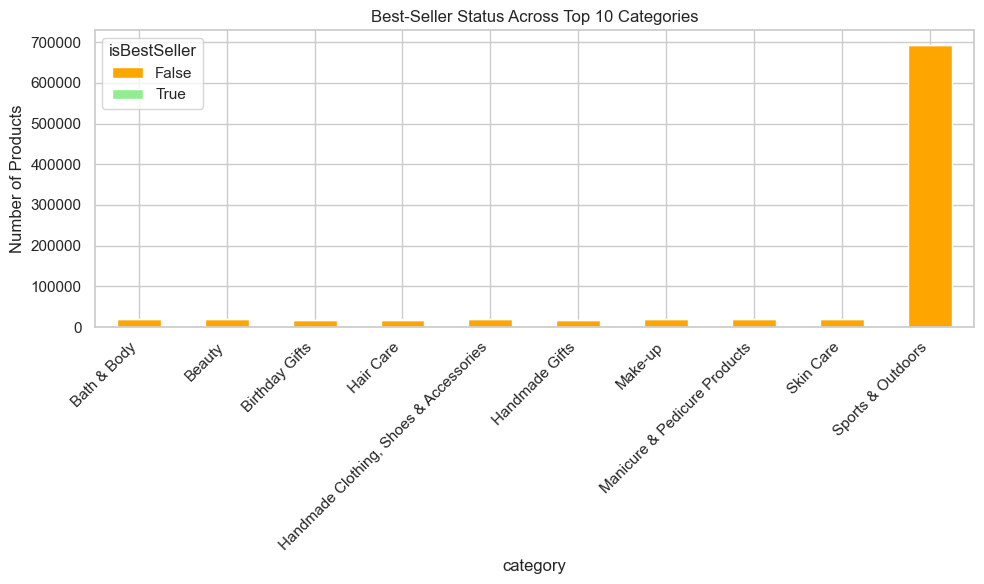

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

# 1. Crosstab Analysis
crosstab = pd.crosstab(df_clean['category'], df_clean['isBestSeller'])
crosstab['Total'] = crosstab[False] + crosstab[True]
crosstab['BestSellerProp'] = crosstab[True] / crosstab['Total']

# Sort by proportion of best-sellers
crosstab_sorted = crosstab.sort_values(by='BestSellerProp', ascending=False)
print(crosstab_sorted.head(10))

# Define top 10 categories by count
top_categories = df_clean['category'].value_counts().head(10).index

# --- Stacked Bar Chart (works fine) ---
crosstab_top10 = pd.crosstab(df_clean[df_clean['category'].isin(top_categories)]['category'], df_clean['isBestSeller'])
crosstab_top10.plot(kind='bar', stacked=True, figsize=(10,6), color=['orange','lightgreen'])
plt.title("Best-Seller Status Across Top 10 Categories")
plt.ylabel("Number of Products")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#From the stacked bar chart, “Sports & Outdoors” show a higher share of Best-Sellers compared to others categories.
#This pattern suggests that customer demand and turnover vary notably across segments.

#Business Implications:
#Underperforming categories could benefit from revised pricing or promotional tactics.

In [275]:
from scipy.stats import chi2_contingency
import numpy as np

# Crosstab for full dataset (all categories)
crosstab_full = pd.crosstab(df_clean['category'], df_clean['isBestSeller'])

# Run Chi-Square test
chi2, p, dof, expected = chi2_contingency(crosstab_full)

print(f"Chi-Square Statistic : {chi2:.2f}")
print(f"Degrees of Freedom   : {dof}")
print(f"P-value              : {p:.5f}")

if p < 0.05:
    print("✅ There is a statistically significant relationship between product category and best-seller status.")
else:
    print("❌ No statistically significant relationship found.")

#Statistical Findings:
#Chi-Square Statistic: ≈ 32142
#p-value: ≈ 0
#p= 0 indicating a statistically significant relationship between product category and best-seller status.

Chi-Square Statistic : 32142.63
Degrees of Freedom   : 295
P-value              : 0.00000
✅ There is a statistically significant relationship between product category and best-seller status.


In [276]:
# Cramér's V
n = crosstab_full.to_numpy().sum()
cramers_v = np.sqrt(chi2 / (n * (min(crosstab_full.shape) - 1)))
print(f"Cramér’s V: {cramers_v:.3f}")

# Interpretation guide:
# 0 – 0.1  = Very Weak
# 0.1 – 0.3 = Weak
# 0.3 – 0.5 = Moderate
# > 0.5     = Strong
#Cramér’s V: ≈ 0.123
#Very Weak association.

Cramér’s V: 0.123


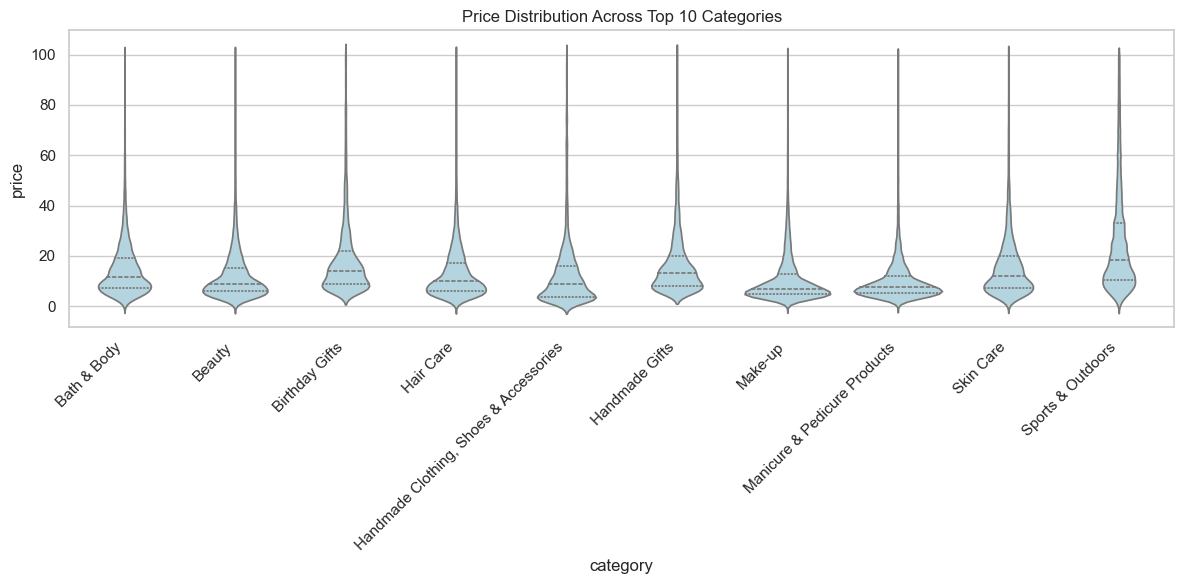

C:\Users\rahal\AppData\Local\Temp\ipykernel_26328\346864390.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_prices = df_clean.groupby('category')['price'].median().sort_values(ascending=True)
C:\Users\rahal\AppData\Local\Temp\ipykernel_26328\346864390.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prices_top10 = df_top10.groupby('category')['price'].mean().sort_values(ascending=True)


Category with highest median price: category
Office Paper Products    4.37
Name: price, dtype: float64


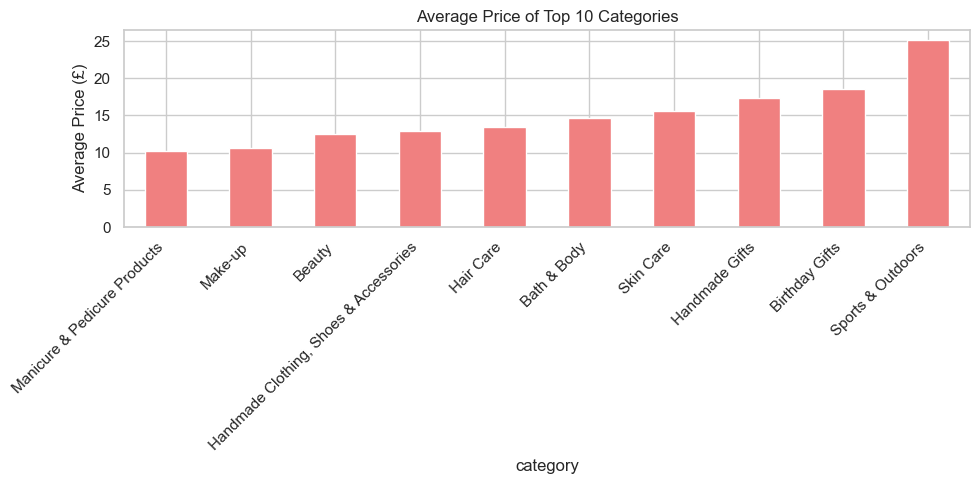

Category with highest average price: category
Manicure & Pedicure Products    10.231825
Name: price, dtype: float64


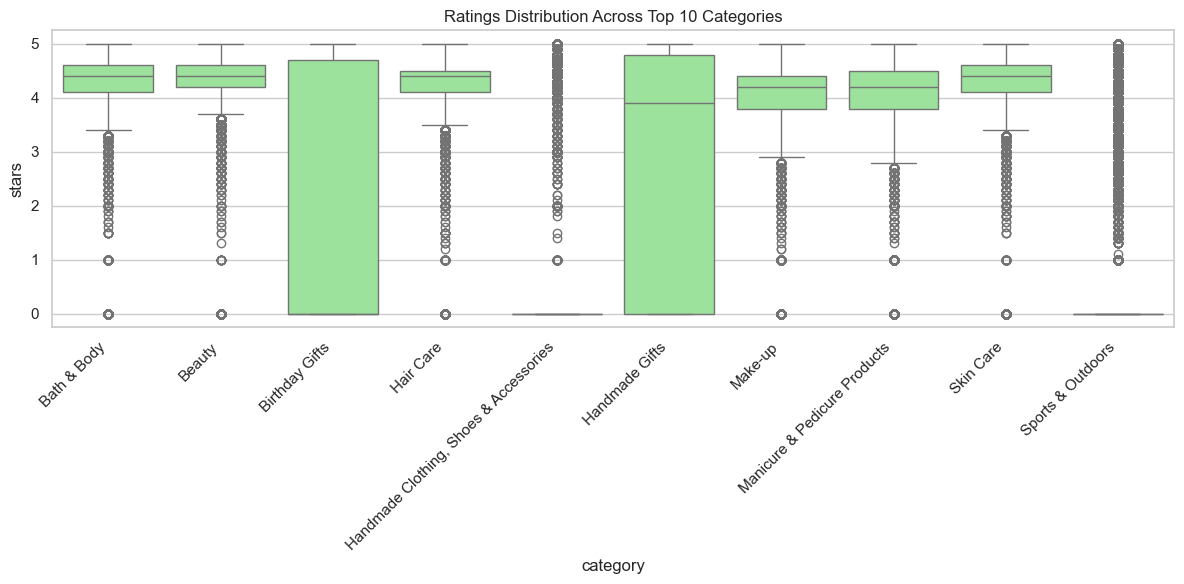

Category with highest median rating: category
3D Printing & Scanning    0.0
Name: stars, dtype: float64


C:\Users\rahal\AppData\Local\Temp\ipykernel_26328\346864390.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_ratings = df_clean.groupby('category')['stars'].median().sort_values(ascending=True)


In [ ]:
# --- Create clean df_top10 ---
df_top10 = df_clean[df_clean['category'].isin(top_categories)].copy()
df_top10['category'] = df_top10['category'].astype('category')

# ✅ Remove unused category levels
df_top10['category'] = df_top10['category'].cat.remove_unused_categories()

# --- Violin Plot ---
plt.figure(figsize=(12,6))
sns.violinplot(x='category', y='price', data=df_top10, inner='quartile', color='lightblue')
plt.title("Price Distribution Across Top 10 Categories")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#The violin plot revealed that Sport & Outdoors, Birthday Gifts and Handmade Gifts have both higher medians and wider price dispersion, indicating a broader product range.

# --- Highest median price ---
median_prices = df_clean.groupby('category')['price'].median().sort_values(ascending=True)
print("Category with highest median price:", median_prices.head(1))

# --- Bar Chart: Average Price ---
avg_prices_top10 = df_top10.groupby('category')['price'].mean().sort_values(ascending=True)
avg_prices_top10.plot(kind='bar', figsize=(10,5), color='lightcoral')
plt.title("Average Price of Top 10 Categories")
plt.ylabel("Average Price (£)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Category with highest average price:", avg_prices_top10.head(1))

#The bar chart confirmed Sport & Outdoors as commanding the highest average price.

# --- Box Plot: Ratings ---
plt.figure(figsize=(12,6))
sns.boxplot(x='category', y='stars', data=df_top10, color='lightgreen')
plt.title("Ratings Distribution Across Top 10 Categories")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Ratings box plots showed that Birthday Gifts and Handmade Gifts tends to receive the highest median star rating, while Sport & Outdoors ratings are lower and more dispersed.

# --- Highest median rating ---
median_ratings = df_clean.groupby('category')['stars'].median().sort_values(ascending=True)
print("Category with highest median rating:", median_ratings.head(1))

In [ ]:
# Business Implications:
#Categories with consistently high ratings suggest strong customer satisfaction—potential to upsell or expand offerings.
#Low-rated or highly variable categories should be investigated for quality or pricing mismatches.

In [278]:
# Pearson correlation
corr, p_val = pearsonr(df_clean['price'], df_clean['stars'])
print(f"Correlation between price and stars: {corr}, p-value: {p_val}")


Correlation between price and stars: -0.07767299878181355, p-value: 0.0


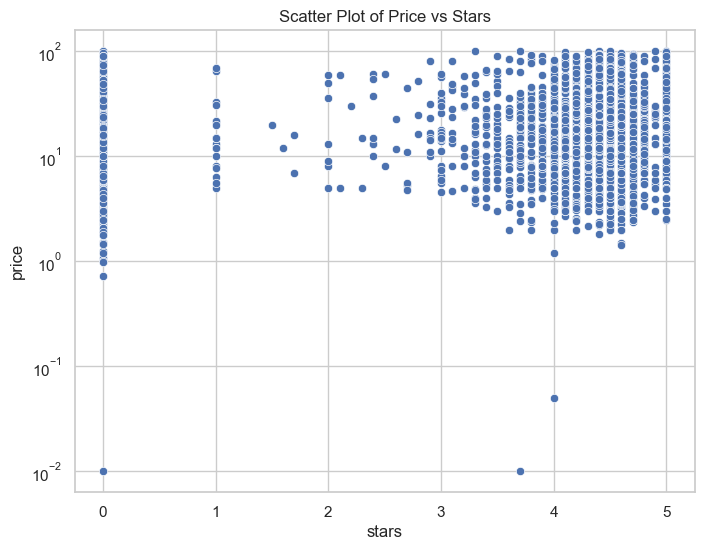

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='stars', y='price', data=df_clean.sample(5000))  # sample to reduce plotting time
plt.yscale('log')  # optional, if price is skewed
plt.title("Scatter Plot of Price vs Stars")
plt.show()

#The scatter plot shows no clear linear trend, suggesting that expensive products don’t necessarily receive higher ratings.

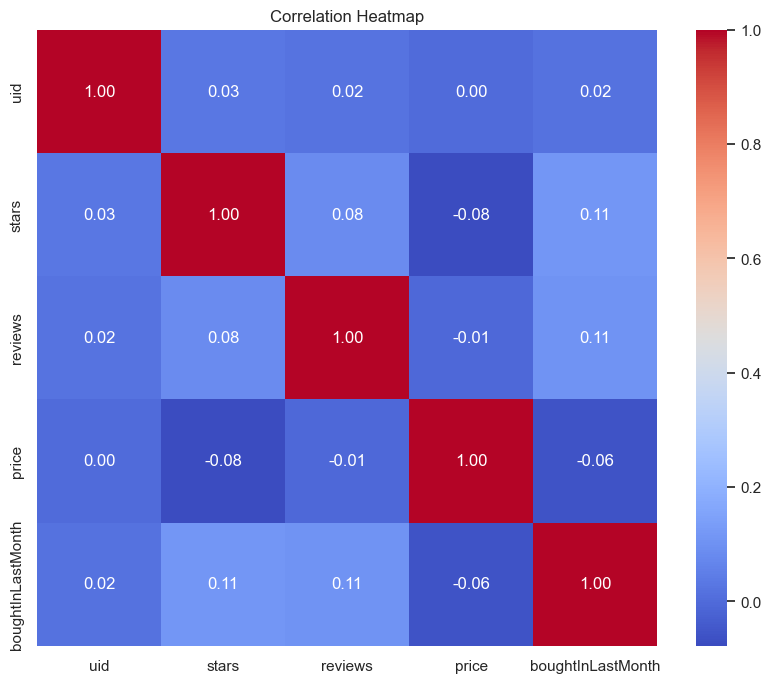

In [ ]:
numeric_cols = df_clean.select_dtypes(include=['float64','int64']).columns
plt.figure(figsize=(10,8))
sns.heatmap(df_clean[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#The heatmap confirms that price and rating are weakly correlated compared to other numerical features like review count.

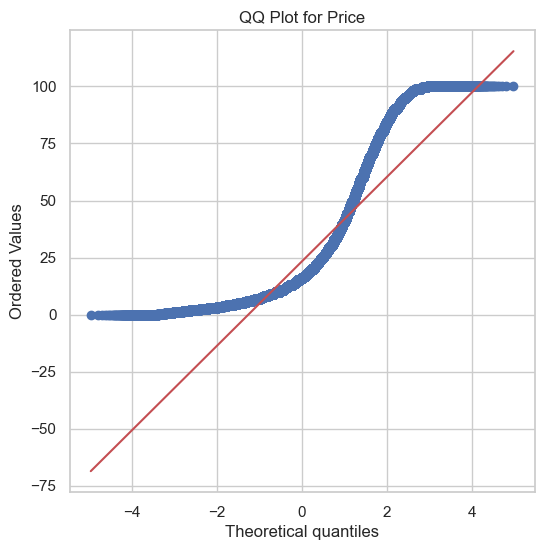

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
stats.probplot(df_clean['price'], dist="norm", plot=plt)
plt.title("QQ Plot for Price")
plt.show()

#QQ plot indicates price distribution is right-skewed, typical for e-commerce data—most products are low-priced with a few premium outliers.

In [ ]:
#Customer satisfaction appears largely independent of price level.
#Competitive advantage may rely more on product quality and service rather than pricing alone.
#Recommend segmenting products by price tier to test whether high-end segments differ in rating behavior.